# 목표: 집값을 예측하는 모델을 만들고 캐글에 제출까지 해보자!

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

# 베이스 라인 세팅

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

# 필요한 라이브러리들을 호출한다

## 1. 데이터 불러오기

In [ ]:
data = pd.read_csv('/content/train.csv')
sub = pd.read_csv('/content/test.csv')
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

# 데이터를 불러오고 훈련용과 테스트용의 문제 수와 데이터를 체크한다
# 테스트용 데이터에 칼럼이 하나 부족한걸 확인 할 수있다

train data dim : (15035, 21)
sub data dim : (6468, 20)


## 2. 데이터 분석하기

### 2.1 데이터 정리

In [ ]:
y = data['price']
del data['price']

print(data.columns)

# 정답 레이블인 price칼럼을 데이터셋에서 빼서 변수 y에 따로 저장한다

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [ ]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

# 데이터 분석 및 정리를 하기전 train 데이터와 test 데이터를 concat함수를 이용해 합친다
# 합쳐서 데이터를 처리할 경우 두번할 일을 한번에 할수 있어서 편리하다
# 나중에 다시 분리하기 위해 미리 train데이터의 개수를 세어둔다(len)

21503


In [ ]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [ ]:
print(data.shape)

# 두개의 데이터 셋이 잘 합쳐진걸 확인 할 수있다

(21503, 20)


### 2.2 널값확인

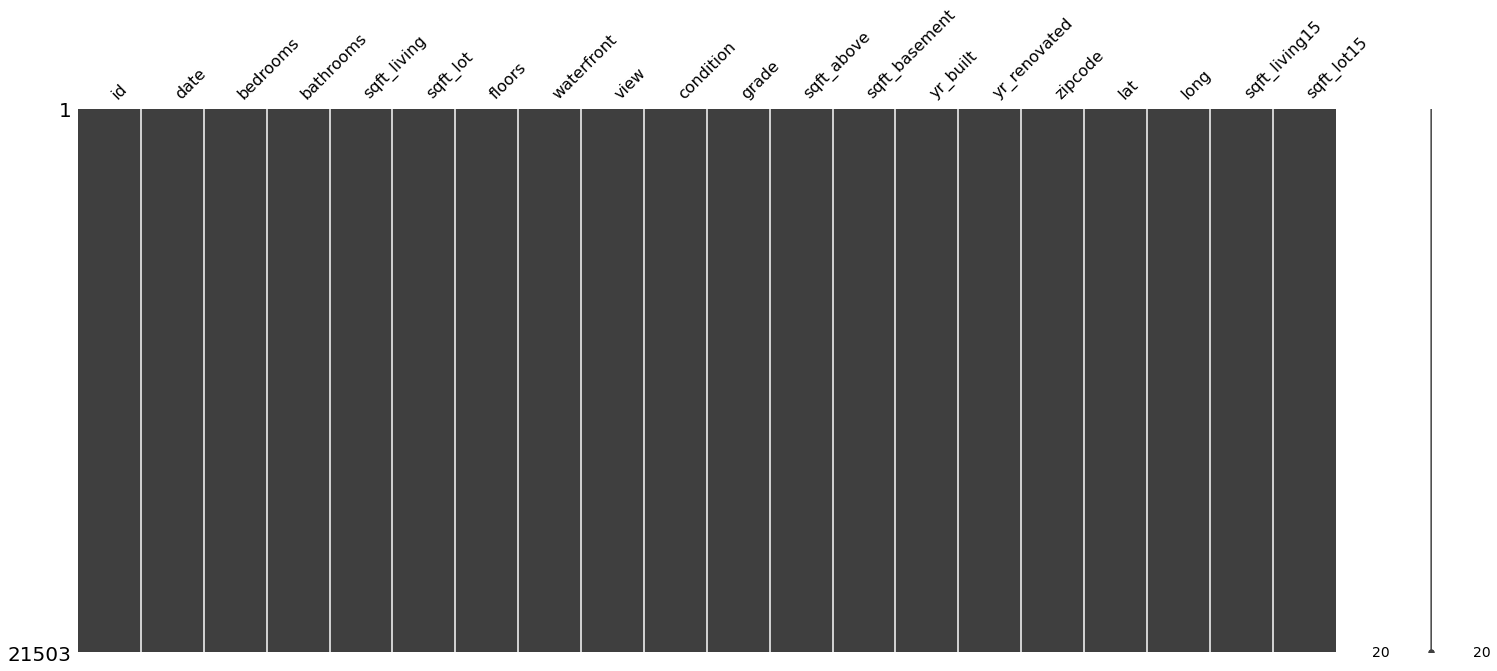

In [ ]:
msno.matrix(data)

In [ ]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

# 전체 칼럼에 결측치가 있는지 체크해주는 방법이다
# for문이 상당히 많이 활용된다는것을 알수 있었고 기억해둬야할 방법이라 생각한다

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [ ]:
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

# 필요없어 보이는 id칼럼을 제거한후 확인한다

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [ ]:
data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()

# date 칼럼의 연월 부분만 사용하기 위해 문자열을 6에서 끊었다 

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 2.3 데이터 시각화

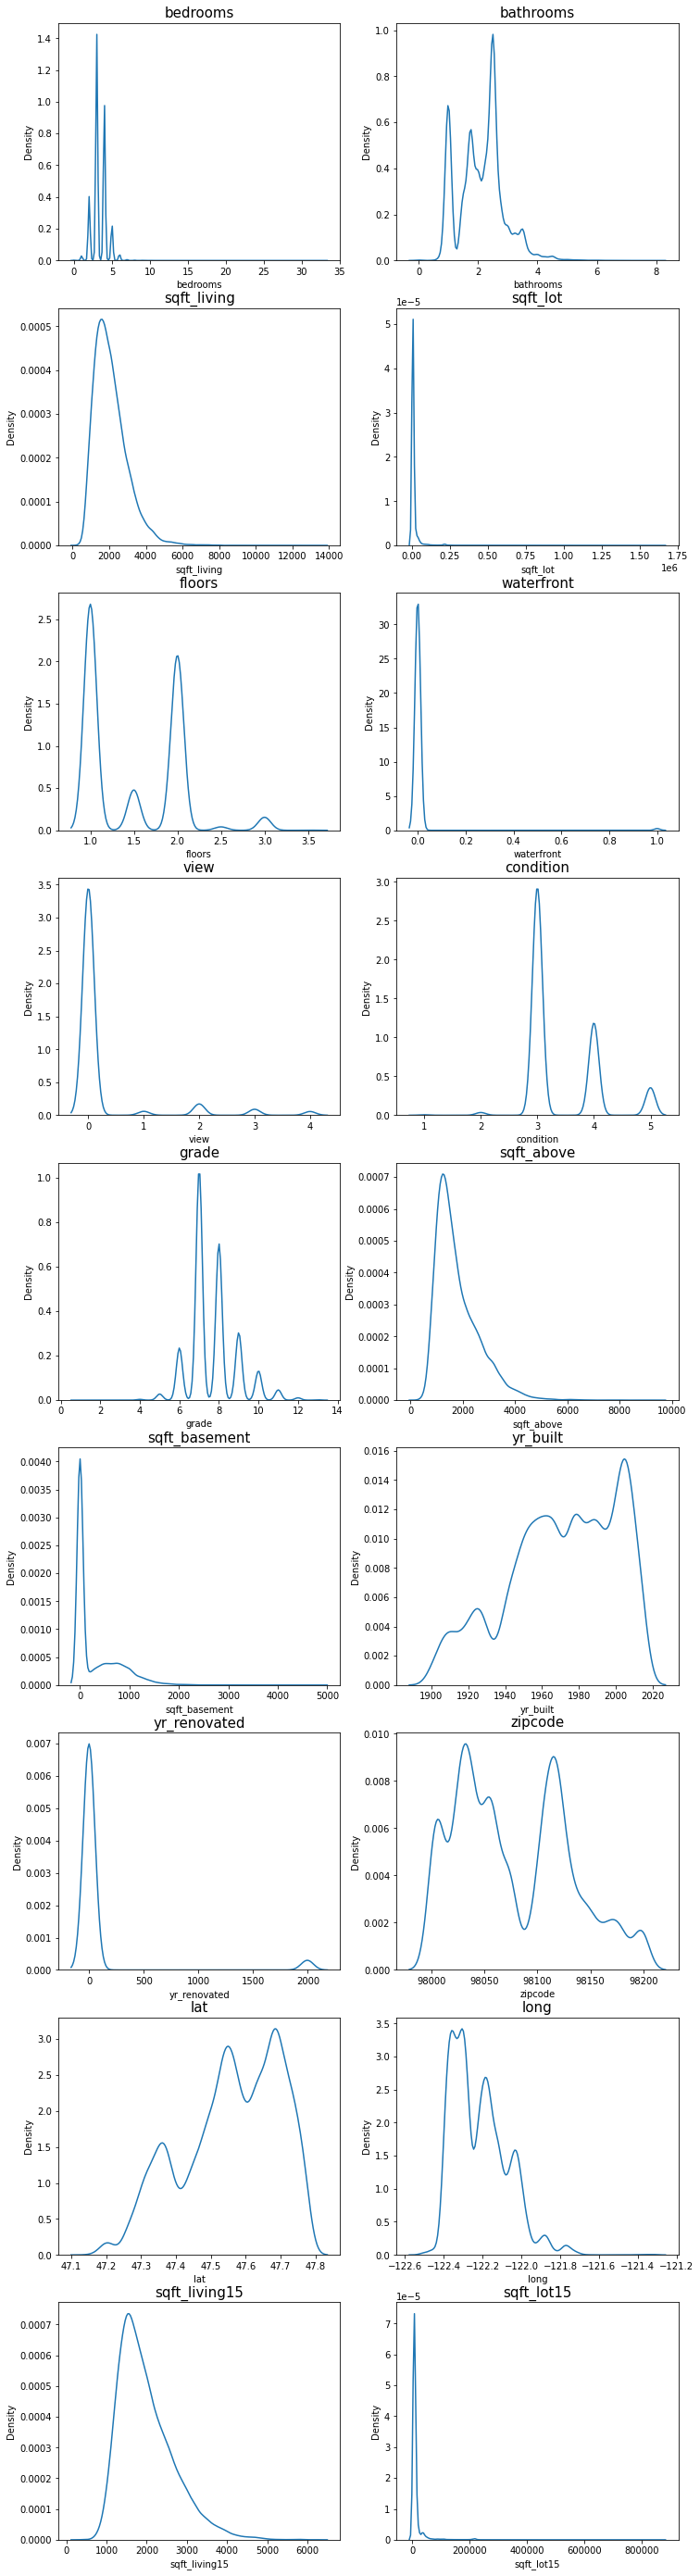

In [ ]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

# 데이터 시각화를 통해 insight를 얻고자함
# 여기서도 for문이 사용되었다
# 0과1사이에 데이터가 쏠려있는 여러 칼럼들이 있다

In [ ]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

# 쏠려있는 데이터의 목록을 리스트로 만든다
# 만든 리스트의 칼럼들을 로그 스케일링 해준다
# 로그 스케일링을 하는 이유로는 0과1에 몰려있는 데이터는 넓게 펴주고 퍼져있는 데이터는 모아준다
# ==> 데이터를 더 잘 분석하기 위해??

# log스케일링을 할때 log를 쓰는게 아니라 log1p를 쓰는이유
# log함수의 x값이 0일때 -infinity가 되기 때문에 컴퓨터에서 처리를 해줄수 없다
# 따라서 x값들에 +1을 해줘서 0값들을 1로 바꿔줌으로써 오류를 막는다

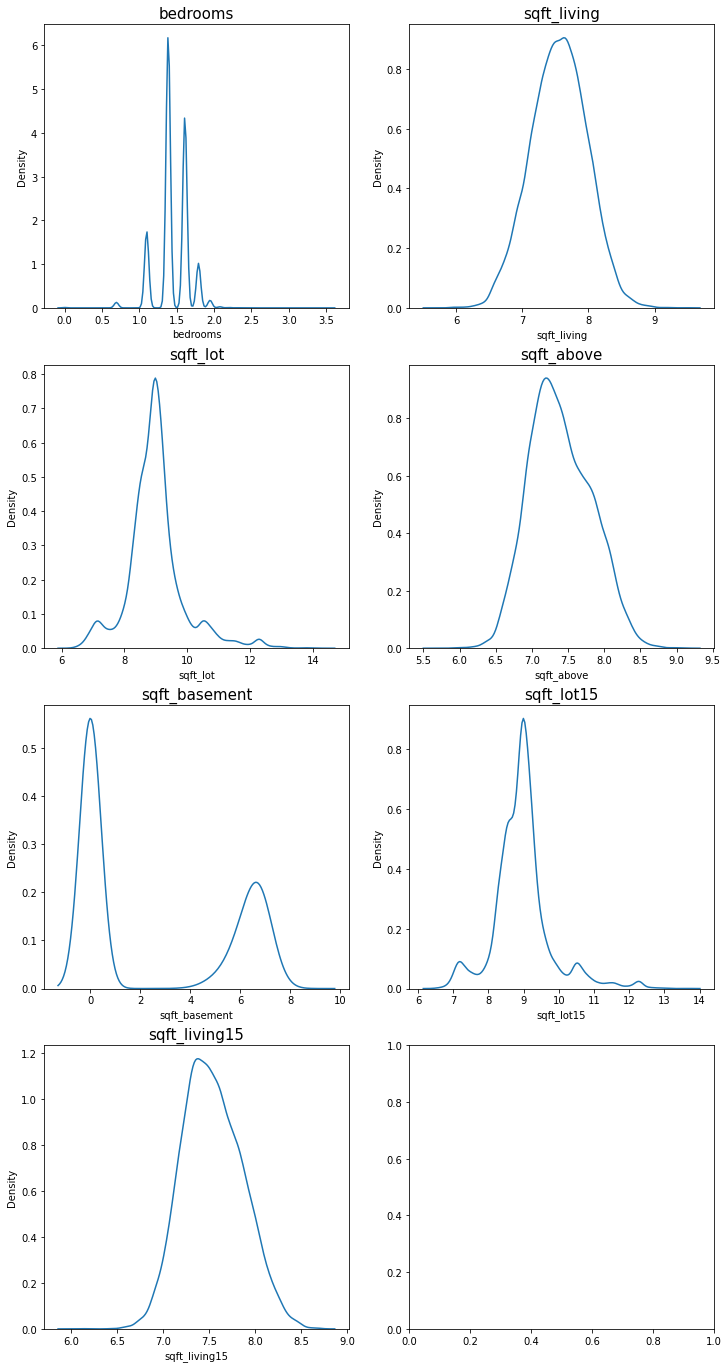

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

# 로그스케일링한 것만 다시 시각화 진행한다

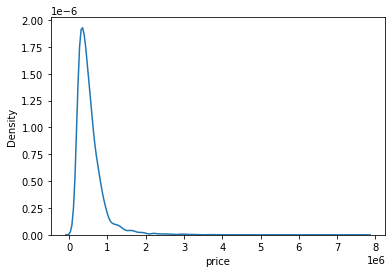

In [ ]:
sns.kdeplot(y)
plt.show()

# y값 데이터 시각화

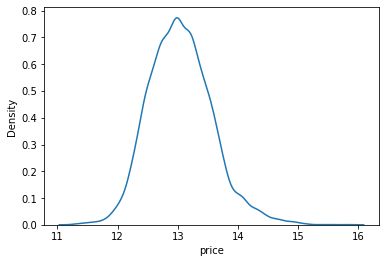

In [ ]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

# y값도 로그스케일링해서 시각화 한다

In [ ]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

# 데이터 분석이 끝났으니 다시 합친데이터를 훈련용과 테스트용 나눠준다

(15035, 19)
(6468, 19)


## 3. 앙상블

In [ ]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

 # 

In [ ]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

# 교차검증을 하기 위한 함수 생성

In [ ]:
get_cv_score(models)

# 교차검증

Model: GradientBoosting, CV score:0.8598
[00:04:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:04:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:04:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:04:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:04:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model: XGBoost, CV score:0.8624
Model: LightGBM, CV score:0.8819


In [ ]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

# 각 모델에 대한 예측 결과를 평균내어주는 함수 생성
# model 딕셔너리안에 있는 모델을 모두 x와 y로 학습시킨 후 predictions에 예측값을 모아서 평균한 값을 반환

In [ ]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

# 위에서 생성한 함수를 이용해 예측값 생성

[00:04:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
6468


array([ 562566.39221578,  389660.68147617, 1340643.45409443, ...,
        438058.69137012,  345498.01852609,  414241.23776683])

In [ ]:
submission = pd.read_csv('/content/sample_submission.csv')
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [ ]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

# 결과를 시각화 한다

,id,price
0,15035,5.625664e+05
1,15036,3.896607e+05
2,15037,1.340643e+06
3,15038,3.317573e+05
4,15039,2.966855e+05


In [ ]:
my_submission_path = '/content/submission.csv'
result.to_csv('/content/submission.csv', index=False)

print(my_submission_path)

# 제출파일 저장

/content/submission.csv


# 1차 baseline 완료

------------------------------------------------------------------------------------------------

# 2.하이퍼 파라미터 튜닝

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [ ]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [ ]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

# 위와같이 date 칼럼의 연월만 추출

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [ ]:
y = train['price']
del train['price']

print(train.columns)

# 트레인 데이터에서 price 라벨 추출

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [ ]:
del train['id']

print(train.columns)

# id 칼럼 제거

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [ ]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

# test셋도 동일하게 진행

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [ ]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

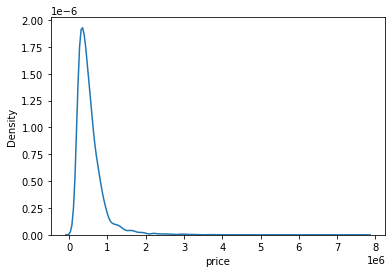

In [ ]:
sns.kdeplot(y)
plt.show()



In [ ]:
y = np.log1p(y)
y

# y데이터 로그스케일링

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

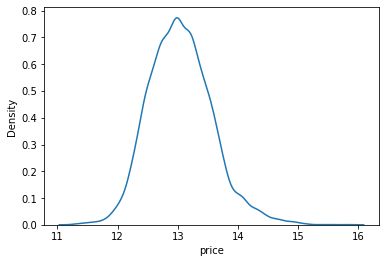

In [ ]:
sns.kdeplot(y)
plt.show()

# y데이터 시각화

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 데이터 학습에 필요한 라이브러리 호출

In [ ]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

# rmse 함수 호출

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# 앙상블 학습 모델 호출

In [ ]:
random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

# random_state에 랜덤 시드에 고정값 세팅해서 학습결과를 항상 동일하게 재현시킴
# 모델 리스트 생성

In [ ]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [ ]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__
 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

# 랜덤값을 고정해서 훈련용 데이터 분리시킨후 모델을 학습시킨다
# 학습시킨후 나온 예측값을 아까 빼놓은 y 레이블과 함께 rmse메서드로 오차값을 뽑는다
# rmse함수를 통해 로스값을 뽑고 df에 저장한다

[00:05:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'GradientBoostingRegressor': 128360.19649691365,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562,
 'XGBRegressor': 131067.44622809246}

In [ ]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

# 위의 과정을 함수 하나로 요약
# 데이터를 분리하고 각 모델별로 학습해서 나온 예측값과 정답에 오차를 저장후 출력한다 

In [ ]:
from sklearn.model_selection import GridSearchCV

# 최적의 하이퍼 파라미터 찾아주는 그리드서치 라이브러리 불러온다

In [ ]:
param_grid = {
    'n_estimators': [100, 300, 500, 800, 1000],
    'max_depth': [1, 10],
}

# 그리드서치 파라미터 범위 설정(탐색할 하이퍼 파라미터 범위를 늘렸다)
# xgboost 관련 하이퍼 파라미터

In [ ]:
model = LGBMRegressor(random_state=random_state)

# 그다음 모델인 LightGBM

In [ ]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

# 하이퍼 파라미터 범위 설정
# 범위가 너무 많아서 시간이 오래 걸리는 단점이 있다

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10],
                         'n_estimators': [100, 300, 500, 800, 1000]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
grid_model.cv_results_

{'mean_fit_time': array([0.37746396, 0.7382751 , 1.14745679, 1.72772155, 2.18283639,
        1.5937088 , 3.36134453, 5.32165236, 8.13946595, 9.84370103]),
 'mean_score_time': array([0.02882848, 0.0717103 , 0.11091685, 0.16071558, 0.2382267 ,
        0.09215579, 0.26467533, 0.3779727 , 0.7092845 , 0.73750191]),
 'mean_test_score': array([-0.05502043, -0.04202811, -0.0390486 , -0.03725702, -0.03651692,
        -0.02702714, -0.02612748, -0.02624516, -0.02655175, -0.02673912]),
 'param_max_depth': masked_array(data=[1, 1, 1, 1, 1, 10, 10, 10, 10, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[100, 300, 500, 800, 1000, 100, 300, 500, 800, 1000],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth':

In [ ]:
params = grid_model.cv_results_['params']
params

# 그리드 서치할 파라미터의 종류를 파라미터에 넣는다

[{'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 1, 'n_estimators': 300},
 {'max_depth': 1, 'n_estimators': 500},
 {'max_depth': 1, 'n_estimators': 800},
 {'max_depth': 1, 'n_estimators': 1000},
 {'max_depth': 10, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 300},
 {'max_depth': 10, 'n_estimators': 500},
 {'max_depth': 10, 'n_estimators': 800},
 {'max_depth': 10, 'n_estimators': 1000}]

In [ ]:
score = grid_model.cv_results_['mean_test_score']
score


array([-0.05502043, -0.04202811, -0.0390486 , -0.03725702, -0.03651692,
       -0.02702714, -0.02612748, -0.02624516, -0.02655175, -0.02673912])

In [ ]:
results = pd.DataFrame(params)
results['score'] = score

results

# 각각의 파라미터를 넣었을때의 스코어 결과값을 출력한다
# 스코어 결과가 음수로 나오는 이유는

,max_depth,n_estimators,score
0,1,100,-0.055020
1,1,300,-0.042028
2,1,500,-0.039049
3,1,800,-0.037257
4,1,1000,-0.036517
5,10,100,-0.027027
6,10,300,-0.026127
7,10,500,-0.026245
8,10,800,-0.026552
9,10,1000,-0.026739


In [ ]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

# 위의 함수에서 mse에 음수를 취한 neg_mean_squared_error를 사용했기 때문에 -1을 곱해준후 root를 취한다
# 데이터 프레임으로 출력

,max_depth,n_estimators,score,RMSE
0,1,100,-0.055020,0.234564
1,1,300,-0.042028,0.205008
2,1,500,-0.039049,0.197607
3,1,800,-0.037257,0.193021
4,1,1000,-0.036517,0.191094
5,10,100,-0.027027,0.164399
6,10,300,-0.026127,0.161640
7,10,500,-0.026245,0.162004
8,10,800,-0.026552,0.162947
9,10,1000,-0.026739,0.163521


In [ ]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

# 컬럼이름 RMSE로 변환

,max_depth,n_estimators,score,RMSLE
0,1,100,-0.055020,0.234564
1,1,300,-0.042028,0.205008
2,1,500,-0.039049,0.197607
3,1,800,-0.037257,0.193021
4,1,1000,-0.036517,0.191094
5,10,100,-0.027027,0.164399
6,10,300,-0.026127,0.161640
7,10,500,-0.026245,0.162004
8,10,800,-0.026552,0.162947
9,10,1000,-0.026739,0.163521


In [ ]:
results = results.sort_values('RMSLE')
results

# RMSLE낮은순으로 새로 정렬

,max_depth,n_estimators,score,RMSLE
6,10,300,-0.026127,0.161640
7,10,500,-0.026245,0.162004
8,10,800,-0.026552,0.162947
9,10,1000,-0.026739,0.163521
5,10,100,-0.027027,0.164399
4,1,1000,-0.036517,0.191094
3,1,800,-0.037257,0.193021
2,1,500,-0.039049,0.197607
1,1,300,-0.042028,0.205008
0,1,100,-0.055020,0.234564


In [ ]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    grid_model.fit(train, y)

    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
   
    results = pd.DataFrame(params)
    results['score'] = score
    
   
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

# 위의 과정을 하나의 함수로 압축
# 그리서서치 모델을 만들고 학습시킨다
# 결과값들을 저장후 생성한 데이터 프레임에 RMSLE값 계산해서 넣고 정렬한다

In [ ]:
param_grid = {
    'n_estimators': [100,300, 500, 800, 1000],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

# estimators가 500일때 가장 좋다고 나왔다
# max_depth 10일때 가장 좋은걸로 나온다

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,max_depth,n_estimators,score,RMSLE
6,10,300,-0.026127,0.161640
7,10,500,-0.026245,0.162004
8,10,800,-0.026552,0.162947
9,10,1000,-0.026739,0.163521
5,10,100,-0.027027,0.164399
4,1,1000,-0.036517,0.191094
3,1,800,-0.037257,0.193021
2,1,500,-0.039049,0.197607
1,1,300,-0.042028,0.205008
0,1,100,-0.055020,0.234564


In [ ]:
model = LGBMRegressor(max_depth=10, n_estimators=1000, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

# 위의 결과에 따른 파라미터로 구성된 모델을 준비하고 학습후, 결과생성

array([13.19495169, 13.11873096, 14.01893003, ..., 13.05179856,
       12.72122862, 13.00310932])

In [ ]:
prediction = np.expm1(prediction)
prediction

# 예측결과에 e를 씌워 원래 스케일로 키운다

array([ 537642.88051594,  498186.08760612, 1225585.45639546, ...,
        465932.667101  ,  334778.91334668,  443790.13608839])

In [ ]:
submission = pd.read_csv('/content/sample_submission.csv')
submission.head()

# submission파일 호출

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [ ]:
submission['price'] = prediction
submission.head()

# submission 데이터 프레임에 예측값을 덮어 씌운다
# 제출할데이터 완성

,id,price
0,15035,5.376429e+05
1,15036,4.981861e+05
2,15037,1.225585e+06
3,15038,2.809225e+05
4,15039,3.260536e+05


In [ ]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format('/content', 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/content/submission_lgbm_RMSLE_0.164399.csv


In [ ]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    
    submission_path = join('/content', 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format('/content', model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

# 위의 과정 하나의 메서드로 압축하는 방법
# 모델을 train데이터 셋으로 학습시킨후 test데이터로 예측한 값을 e를 취해 원래 값으로 변환 후 
# 예측값을 submission 파일에 넣어준다

In [ ]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0162')

# 예측결과저장한다

/content/submission_lgbm_RMSLE_0.0162.csv saved!


# 3. 회고

캐글에서 데이터를 가져와서 집값을 예측하는 과정을 진행했다.
평소 하던 캐글 필사와 달리 실제 데이터를 로그 스케일링등 분석들을 진행해보니 신선했다. 
마지막에 그리드 서치를 이용해 하이퍼 파라미터를 수정하고 최적의 파라미터를 찾는 과정을 진행중에 최적의 파라미터인 300 보다 1000이 왜 스코어 점수가 더 낮은지 잘 모르겠다
좀 더 공부해서 왜그런지 파악하고 하이퍼 파라미터를 정말 잘 이해하고 쓸수있는 날이 왔으면 좋겠다

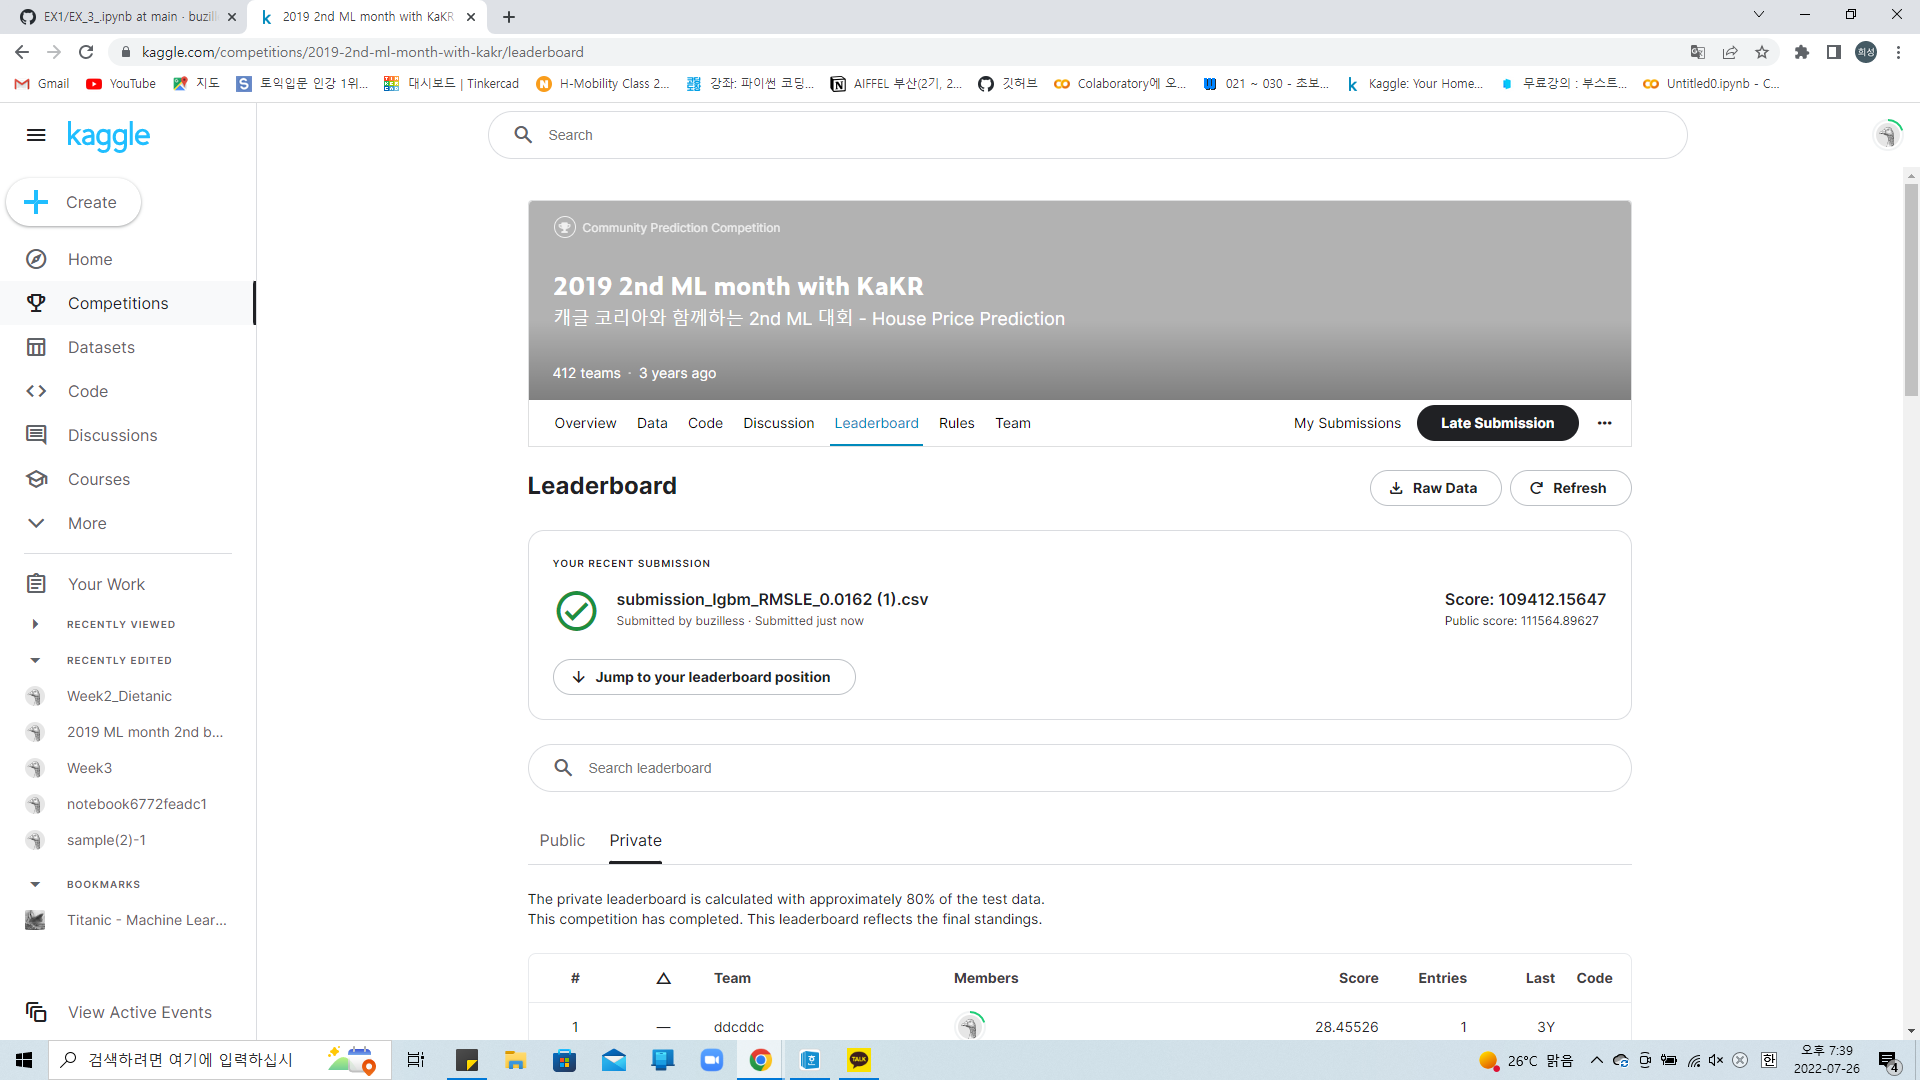